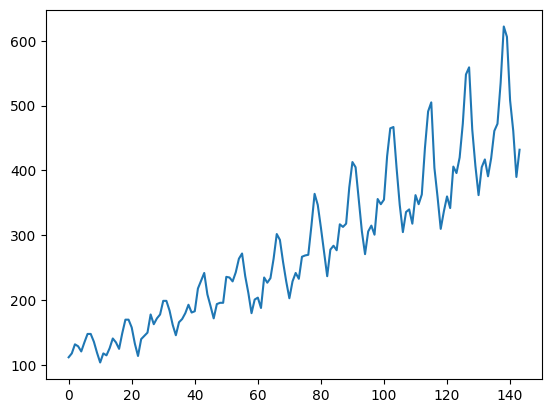

In [7]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv('data/airline-passengers.csv')
timeseries = df[["Passengers"]].values.astype('float32')

plt.plot(timeseries)
plt.show()

In [8]:
train_size = int(len(timeseries) * 0.67)
test_size = len(timeseries) - train_size
train,test = timeseries[:train_size], timeseries[train_size:]

In [9]:
import torch

def create_dataset(dataset,lookback):
    """
    Transform a time series dataset into a prediction dataset.
    :param dataset: A numpy array of time series data, first dimenstion is time step
    :param lookback: Size of window for prediction
    :return: A torch tensor of input data and a torch tensor of target data
    """
    X, y = [], []
    for i in range(len(dataset) - lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)


In [10]:
lookback = 1
X_train , y_train = create_dataset(train,lookback)
X_test , y_test = create_dataset(test,lookback)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([95, 1, 1]) torch.Size([95, 0])
torch.Size([47, 1, 1]) torch.Size([47, 0])


In [11]:
import torch.nn as nn

class AirModel(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.lstm = nn.LSTM(input_size=1,hidden_size=50,num_layers=1,batch_first=True)
        self.linear = nn.Linear(50,1)
    def forward(self,x):
        x,_ = self.lstm(x)
        x  = self.linear(x)
        return x
        

In [12]:
import numpy as np
import torch.optim as optim
import torch.utils.data as data

model = AirModel()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)

n_epochs = 2000
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

Epoch 0: train RMSE nan, test RMSE nan


d:\Workspace\ML and Deep Learning\PyTorch-Intro\env\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([8, 0])) that is different to the input size (torch.Size([8, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
d:\Workspace\ML and Deep Learning\PyTorch-Intro\env\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([7, 0])) that is different to the input size (torch.Size([7, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
d:\Workspace\ML and Deep Learning\PyTorch-Intro\env\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([95, 0])) that is different to the input size (torch.Size([95, 1, 1])). This will likely lead to 

Epoch 100: train RMSE nan, test RMSE nan
Epoch 200: train RMSE nan, test RMSE nan
Epoch 300: train RMSE nan, test RMSE nan


KeyboardInterrupt: 

C:\Users\mufas\AppData\Local\Temp\ipykernel_20444\3103842424.py:6: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  train_plot[lookback:train_size] = model(X_train)[:, -1, :]
C:\Users\mufas\AppData\Local\Temp\ipykernel_20444\3103842424.py:9: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  test_plot[train_size+lookback:len(timeseries)] = model(X_test)[:, -1, :]


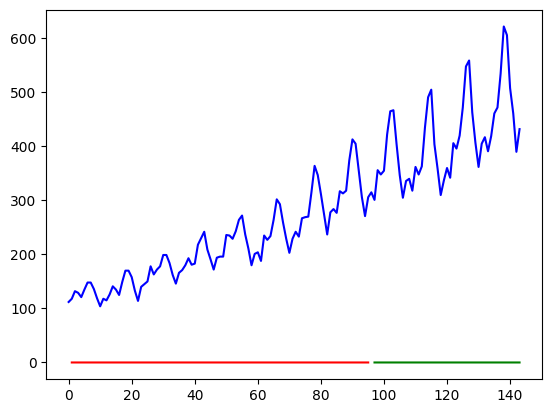

In [7]:
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = model(X_train)[:, -1, :]
    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size+lookback:len(timeseries)] = model(X_test)[:, -1, :]
# plot
plt.plot(timeseries, c='b')
plt.plot(train_plot, c='r')
plt.plot(test_plot, c='g')
plt.show()